# Project: Decoding Molecules From Fingerprints.
## Group Members:
### Qi Chen, e-mail: gusqichr@student.gu.se
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
***

In [34]:
import zipfile
import pandas as pd
import numpy as np
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools
from IPython.display import display
from joblib import Parallel, delayed

In [6]:
# Path to the data
zip_file_path = '../data/final_chembl.zip'

with zipfile.ZipFile(zip_file_path, 'r') as z:
    file_list = z.namelist()

    csv_filename = file_list[0]

    # Read the file as a pandas DataFrame
    with z.open(csv_filename) as f:
        df = pd.read_csv(f)

df.head()

,ChEMBL ID,smiles,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,NumBridgeheadAtoms,LongestAliChain,LargestRing,MolLogLike
0,CHEMBL3897759,Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5ccc(F)c(F)c5)C...,13.506757,-0.836612,13.506757,0.011403,0.294586,544.650,510.378,544.276216,...,0,0,0,0,0,0,0,1,6,-12.275704
1,CHEMBL3935110,Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5cc(F)ccc5F)CC4...,13.986498,-0.441178,13.986498,0.012570,0.294586,544.650,510.378,544.276216,...,0,0,0,0,0,0,0,1,6,-12.228626
2,CHEMBL3347413,N#Cc1cc(Cl)cc(Oc2cc(CCc3cccnc3)[nH]c(=O)c2Cl)c1,12.093976,-0.437141,12.093976,0.061471,0.699111,386.238,373.134,385.038482,...,0,0,0,0,0,0,0,2,6,-11.894518
3,CHEMBL1739263,N=C(N)c1ccc(-c2sc(-c3ccc(C(=N)N)cc3)c3c2OCCO3)cc1,7.537508,0.042215,7.537508,0.042215,0.410744,378.457,360.313,378.115047,...,0,0,0,1,0,0,0,0,6,-12.655379
4,CHEMBL3917493,O=C(C=Cc1cccs1)c1cccc(NC(=O)c2cc(-c3ccncc3)[nH...,12.517530,-0.360849,12.517530,0.130332,0.363273,400.463,384.335,400.099397,...,0,0,0,1,0,0,0,0,6,-11.901545


In [11]:
# Sub Dataframe of ChEMBL ID and SMILES
smiles_df = df[['ChEMBL ID', 'smiles']].copy()

PandasTools.AddMoleculeColumnToFrame(smiles_df, 'smiles', 'Molecule')

C:\Users\nilsd\anaconda3\lib\site-packages\rdkit\Chem\PandasTools.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,ChEMBL ID,smiles,Molecule
0,CHEMBL3897759,Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5ccc(F)c(F)c5)C...,<rdkit.Chem.rdchem.Mol object at 0x0000016C928...
1,CHEMBL3935110,Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5cc(F)ccc5F)CC4...,<rdkit.Chem.rdchem.Mol object at 0x0000016CBAA...
2,CHEMBL3347413,N#Cc1cc(Cl)cc(Oc2cc(CCc3cccnc3)[nH]c(=O)c2Cl)c1,<rdkit.Chem.rdchem.Mol object at 0x0000016CBAA...
3,CHEMBL1739263,N=C(N)c1ccc(-c2sc(-c3ccc(C(=N)N)cc3)c3c2OCCO3)cc1,<rdkit.Chem.rdchem.Mol object at 0x0000016CBAA...
4,CHEMBL3917493,O=C(C=Cc1cccs1)c1cccc(NC(=O)c2cc(-c3ccncc3)[nH...,<rdkit.Chem.rdchem.Mol object at 0x0000016CBAA...


C:\Users\nilsd\anaconda3\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


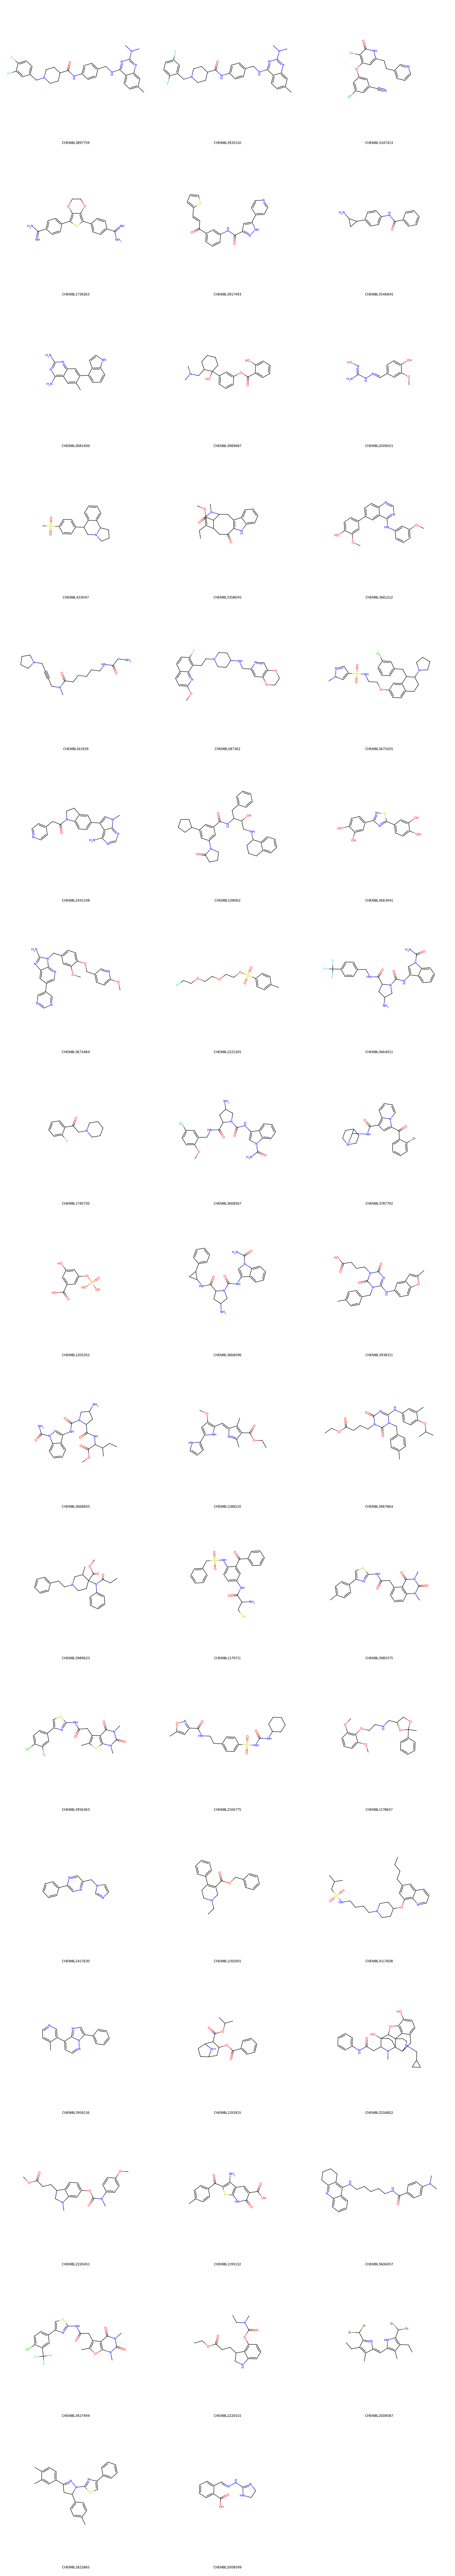

In [25]:
# Prepare molecules and ChEMBL IDs for display
mols = smiles_df['Molecule'].tolist()
ids = smiles_df['ChEMBL ID'].tolist()

img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(700, 700), legends=ids)
display(img)

## Convert SMILES to Fingerprints

In [36]:
# Function to generate fingerprint and convert to bit string, creating generator inside the worker
def generate_fingerprint(mol):
    if mol is not None:
        # Create the fingerprint generator inside the worker
        morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
        fp = morgan_generator.GetFingerprint(mol)
        return np.array(list(fp.ToBitString())).astype(int)
    return None

# Use Parallel processing for fingerprint generation
num_cores = -1
smiles_df['FingerprintBits'] = Parallel(n_jobs=num_cores)(delayed(generate_fingerprint)(mol) for mol in smiles_df['Molecule'])

# Display the DataFrame with FingerprintBits
smiles_df.head()

C:\Users\nilsd\AppData\Local\Temp\ipykernel_21840\2303451345.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smiles_df['FingerprintBits'] = Parallel(n_jobs=num_cores)(delayed(generate_fingerprint)(mol) for mol in smiles_df['Molecule'])


,ChEMBL ID,smiles,Molecule,Fingerprint,FingerprintBits
0,CHEMBL3897759,Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5ccc(F)c(F)c5)C...,<rdkit.Chem.rdchem.Mol object at 0x0000016C928...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL3935110,Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5cc(F)ccc5F)CC4...,<rdkit.Chem.rdchem.Mol object at 0x0000016CBAA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL3347413,N#Cc1cc(Cl)cc(Oc2cc(CCc3cccnc3)[nH]c(=O)c2Cl)c1,<rdkit.Chem.rdchem.Mol object at 0x0000016CBAA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL1739263,N=C(N)c1ccc(-c2sc(-c3ccc(C(=N)N)cc3)c3c2OCCO3)cc1,<rdkit.Chem.rdchem.Mol object at 0x0000016CBAA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL3917493,O=C(C=Cc1cccs1)c1cccc(NC(=O)c2cc(-c3ccncc3)[nH...,<rdkit.Chem.rdchem.Mol object at 0x0000016CBAA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ..."
